In [0]:
import os
import bs4
import bz2
import tqdm
import requests
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [2]:
base_url = 'https://dumps.wikimedia.org/enwiki/'
index = requests.get(base_url).text
soup_index = bs4.BeautifulSoup(index, 'html.parser')

dumps = [a['href'] for a in soup_index.find_all('a') if 
         a.has_attr('href')]
dumps

['../',
 '20200201/',
 '20200220/',
 '20200301/',
 '20200401/',
 '20200420/',
 '20200501/',
 '20200520/',
 'latest/']

In [7]:
dump_url = base_url + '20200501/'

# Retrieve the html
dump_html = requests.get(dump_url).text
dump_html[:10]

'<!DOCTYPE '

In [8]:
soup_dump = bs4.BeautifulSoup(dump_html, 'html.parser')

files = []
for file in soup_dump.find_all('li', {'class': 'file'}):
    text = file.text
    if 'pages-articles' in text:
        files.append((text.split()[0], text.split()[1:]))
        
files[:5]

[('enwiki-20200501-pages-articles-multistream.xml.bz2', ['17.0', 'GB']),
 ('enwiki-20200501-pages-articles-multistream-index.txt.bz2', ['211.2', 'MB']),
 ('enwiki-20200501-pages-articles-multistream1.xml-p1p30303.bz2',
  ['177.6', 'MB']),
 ('enwiki-20200501-pages-articles-multistream-index1.txt-p1p30303.bz2',
  ['163', 'KB']),
 ('enwiki-20200501-pages-articles-multistream2.xml-p30304p88444.bz2',
  ['211.3', 'MB'])]

In [10]:
files_to_download = [file[0] for file in files if '.xml-p' in file[0]]
len(files_to_download), files_to_download[-5:]

(118,
 ['enwiki-20200501-pages-articles27.xml-p57663462p59163461.bz2',
  'enwiki-20200501-pages-articles27.xml-p59163462p60663461.bz2',
  'enwiki-20200501-pages-articles27.xml-p60663462p62163461.bz2',
  'enwiki-20200501-pages-articles27.xml-p62163462p63663461.bz2',
  'enwiki-20200501-pages-articles27.xml-p63663462p63833989.bz2'])

In [28]:
%%time
if not os.path.exists('./data'):
    !mkdir ./data

data_paths, file_info = [], []
for i, file in enumerate(files_to_download):
    clear_output(wait=True)
    print(f'File {i + 1} / {len(files_to_download)} ...\n')
    path = os.path.join('./data', file)
    if not os.path.exists(path):
        !wget --no-check-certificate {os.path.join(dump_url, file)} -O {path}
        data_paths.append(path)
        file_size = os.stat(path).st_size / 1e6
        file_articles = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file, file_size, file_articles))
    else:
        data_paths.append(path)
        file_size = os.stat(path).st_size / 1e6
        file_number = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file.split('-')[-1], file_size, file_number))
    print('\nOK')

File 118 / 118 ...

--2020-05-21 22:22:55--  https://dumps.wikimedia.org/enwiki/20200501/enwiki-20200501-pages-articles27.xml-p63663462p63833989.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36556405 (35M) [application/octet-stream]
Saving to: ‘./data/enwiki-20200501-pages-articles27.xml-p63663462p63833989.bz2’

./data/enwiki-20200 100%[===================>]  34.86M  4.73MB/s    in 7.7s    

2020-05-21 22:23:03 (4.55 MB/s) - ‘./data/enwiki-20200501-pages-articles27.xml-p63663462p63833989.bz2’ saved [36556405/36556405]


OK
CPU times: user 48.9 s, sys: 13 s, total: 1min 1s
Wall time: 2h 4min 3s


In [29]:
sorted(file_info, key=lambda x: x[1], reverse=True)[:5]

[('enwiki-20200501-pages-articles-multistream14.xml-p6197595p7697594.bz2',
  437.927656,
  1499999),
 ('enwiki-20200501-pages-articles-multistream12.xml-p3926862p5040436.bz2',
  437.003811,
  1113574),
 ('enwiki-20200501-pages-articles-multistream13.xml-p5040437p6197594.bz2',
  432.157889,
  1157157),
 ('enwiki-20200501-pages-articles-multistream11.xml-p3046513p3926861.bz2',
  420.893917,
  880348),
 ('enwiki-20200501-pages-articles12.xml-p3926862p5040436.bz2',
  417.543623,
  1113574)]

In [30]:
sorted(file_info, key=lambda x: x[2], reverse=True)[:5]

[('enwiki-20200501-pages-articles-multistream14.xml-p6197595p7697594.bz2',
  437.927656,
  1499999),
 ('enwiki-20200501-pages-articles-multistream15.xml-p7744801p9244800.bz2',
  413.095403,
  1499999),
 ('enwiki-20200501-pages-articles-multistream16.xml-p9518049p11018048.bz2',
  340.863364,
  1499999),
 ('enwiki-20200501-pages-articles-multistream17.xml-p11539267p13039266.bz2',
  410.595682,
  1499999),
 ('enwiki-20200501-pages-articles-multistream18.xml-p13693074p15193073.bz2',
  383.206414,
  1499999)]

In [31]:
print(f'There are {len(file_info)} partitions.')

There are 118 partitions.


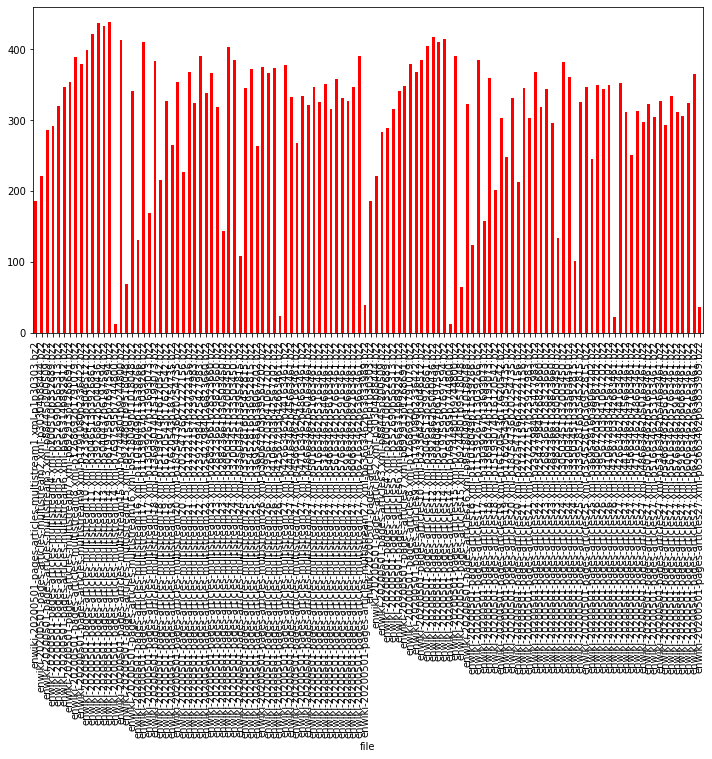

In [32]:
file_df = pd.DataFrame(file_info, columns=['file', 'size (MB)', 'articles']).set_index('file')
file_df['size (MB)'].plot.bar(color='red', figsize=(12, 6));

In [33]:
print(f"The total size of files on disk is {file_df['size (MB)'].sum() / 1e3} GB")

The total size of files on disk is 35.488903070999996 GB


## Parsing the Data

We'll start by working through one of the files and then develop functions that we can run on all of the files. Because we downloaded the data in chunks, we'll be able to parallelize the parsing operations.

In [39]:
data_path = data_paths[65]
data_path

'./data/enwiki-20200501-pages-articles7.xml-p892913p1268691.bz2'

**Test bz2 versus bzcat**
The cells below test the run time of using bz2 versus bzcat to process 1 million lines of the compressed file.

In [40]:
%%timeit -n 3 -r 3

lines = []
for i, line in enumerate(bz2.BZ2File(data_path, 'r')):
    lines.append(line)
    if i > 1e6:
        break

3 loops, best of 3: 6.1 s per loop


In [41]:
%%timeit -n 3 -r 3

lines = []
for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin=open(data_path), 
                         stdout=subprocess.PIPE).stdout):
    lines.append(line)
    if i > 1e6:
        break

3 loops, best of 3: 4.39 s per loop


The subprocess + bzcat approach is nearly twice as fast. Let's run this again and see what kind of data we have.

In [0]:
lines = []

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin=open(data_path), 
                         stdout=subprocess.PIPE).stdout):
    lines.append(line)
    if i > 5e5:
        break

In [52]:
pages = []
page = []
for line in tqdm.tqdm(lines):
    if b'<page>' in line or len(page) > 0:
        page.append(line)
    if b'</page>' in line:
        pages.append(page)
        page = []

100%|██████████| 500002/500002 [00:00<00:00, 851386.35it/s]


In [53]:
pages[0]

[b'  <page>\n',
 b'    <title>Kakabeka Falls</title>\n',
 b'    <ns>0</ns>\n',
 b'    <id>892914</id>\n',
 b'    <revision>\n',
 b'      <id>929037105</id>\n',
 b'      <parentid>917105026</parentid>\n',
 b'      <timestamp>2019-12-03T07:21:10Z</timestamp>\n',
 b'      <contributor>\n',
 b'        <username>Brian Crawford</username>\n',
 b'        <id>322170</id>\n',
 b'      </contributor>\n',
 b'      <minor />\n',
 b'      <comment>fix heading per [[MOS:HEAD]]</comment>\n',
 b'      <model>wikitext</model>\n',
 b'      <format>text/x-wiki</format>\n',
 b'      <text bytes="8475" xml:space="preserve">{{Infobox waterfall\n',
 b'| name = Kakabeka Falls\n',
 b'| photo = thefalls.jpg\n',
 b'| photo_width = 288\n',
 b'| photo_caption = Kakabeka Falls\n',
 b'| location = [[Oliver Paipoonge, Ontario|Oliver Paipoonge]], [[Ontario]], Canada\n',
 b'| coords = {{coord|48.4029|N|89.6256|W|type:waterbody_scale:50000|format=dms|display=inline,title}}\n',
 b'| map = Ontario\n',
 b'| watercourse = [

In [0]:
import xml.sax

class WikiXmlHandler(xml.sax.handler.ContentHandler):
    """Content handler for Wiki XML data using SAX"""
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._pages = []

    def characters(self, content):
        """Characters between opening and closing tags"""
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        """Opening tag of element"""
        if name in ('title', 'text', 'timestamp'):
            self._current_tag = name
            self._buffer = []

    def endElement(self, name):
        """Closing tag of element"""
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page':
            self._pages.append((self._values['title'], self._values['text']))

In [55]:
# Content handler for Wiki XML
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

handler._pages

[]

In [0]:
for l in pages[0]:
    parser.feed(l)

In [57]:
handler._pages

[('Kakabeka Falls',
  '{{Infobox waterfall \n | name = Kakabeka Falls \n | photo = thefalls.jpg \n | photo_width = 288 \n | photo_caption = Kakabeka Falls \n | location = [[Oliver Paipoonge, Ontario|Oliver Paipoonge]], [[Ontario]], Canada \n | coords = {{coord|48.4029|N|89.6256|W|type:waterbody_scale:50000|format=dms|display=inline,title}} \n | map = Ontario \n | watercourse = [[Kaministiquia River]] \n | type = Plunge < ref > {{cite web |url=http://www.start.ca/users/mharris/waterfalls/kakabeka-falls.html |title=Waterfalls of Ontario - Kakabeka Falls |accessdate=2007-09-21 |url-status=dead |archiveurl=https://web.archive.org/web/20070704002118/http://www.start.ca/users/mharris/waterfalls/kakabeka-falls.html |archivedate=2007-07-04 }} < /ref > \n | height = {{convert|40|m|ft|abbr=on}} \n | number_drops = Two \n | average_flow = 50 m³/s (1766 cu ft/s) < ref > Ontario Power Generation, \'\'[http://www.opg.com/safety/water/river/kaministiquia/kakabekaFalls.pdf Kakabeka Falls Total Outflow

In [58]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
    # Stop when 3 articles have been found
    if len(handler._pages) > 2:
        break
        
print([x[0] for x in handler._pages])

['Kakabeka Falls', 'Free Spirits', 'Cincinnati riots of 2001']


## Parsing Articles

In [0]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin=open(data_path), 
                         stdout=subprocess.PIPE).stdout):
    parser.feed(line)
    
    # Stop when 50 articles have been found
    if len(handler._pages) > 50:
        break

To create a wiki representation of the text, we pass the Wikipedia article text to the mwparserfromhell.

In [0]:
# !pip install mwparserfromhell

In [63]:
import mwparserfromhell 

print(handler._pages[6][0])

# Create the wiki article
wiki = mwparserfromhell.parse(handler._pages[6][1])

Northwestern Ontario Sports Hall of Fame


In [64]:
print(type(wiki))
wiki[:100]

<class 'mwparserfromhell.wikicode.Wikicode'>


'{{Unreferenced stub|auto=yes|date=December 2009}} \n {{Infobox Museum \n  |name         = Northwestern'

## Wikicode Search Methods

In [65]:
wikilinks = [x.title for x in wiki.filter_wikilinks()]
print(f'There are {len(wikilinks)} wikilinks.')
wikilinks[:5]

There are 20 wikilinks.


['Thunder Bay', 'Ontario', 'Hall of Fame', 'Thunder Bay', 'Ontario']

In [66]:
wiki.filter_arguments()

[]

In [67]:
wiki.filter_comments()

[]

In [68]:
external_links = [(x.title, x.url) for x in wiki.filter_external_links()]
print(f'There are {len(external_links)} external links.')
external_links[:5]

There are 1 external links.


[('Northwestern Ontario Sports Hall of Fame',
  'http://www.nwosportshalloffame.com/')]

In [72]:
contemporary = wiki.filter(matches = 'contemporary')
contemporary, type(contemporary)

([], list)

In [73]:
wiki.strip_code().strip()[:100]

'The Northwestern Ontario Sports Hall of Fame, established in 1978 in Thunder Bay, Ontario, Canada, i'